# 傾向スコア と Uplift Modeling の比較検証

---

In [65]:
import math
import pandas as pd
import numpy as np
# from sklearn.linear_model import LogisticRegression # sklearnでは正則化項を消せないので、statsmodelsを使う
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from causalml.inference.meta import BaseTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import XGBTRegressor
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import plot_gain
from causalml.metrics import auuc_score
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', 50)

## 0. データ準備

### 0 - 1. データをロード

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv')
feat_cols = ['TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy', 'inc', 'pmoney', 
             'area_kanto', 'area_tokai', 'area_keihanshin', 
             'job_dummy1', 'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6', 'job_dummy7', 
             'fam_str_dummy1', 'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4']

X = df[feat_cols]
Z = df['cm_dummy']
Y_s = df['gamesecond']
Y_d = df['gamedummy']

### 0 - 2. 傾向スコアを計算

In [36]:
# 傾向スコアを計算
X = sm.add_constant(X)
model_lr = sm.Logit(df['cm_dummy'], X)
res_lr = model_lr.fit()
PS = model_lr.predict(res_lr.params)
# res_lr.summary()

Optimization terminated successfully.
         Current function value: 0.542117
         Iterations 6


## 1. 処置効果の推定： アプリ利用時間

### 1 - 1. 処置（TV CM視聴）有無別のプロット

Text(0,1,'log10 without 0')

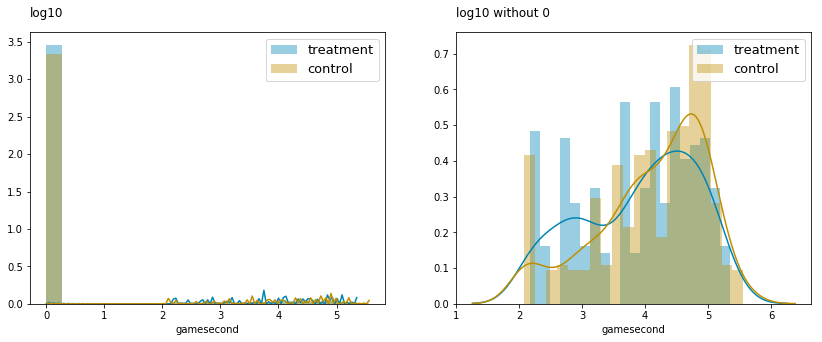

In [17]:
x1 = df[Z == 1]['gamesecond'].apply(lambda x: math.log10(x + 1))
x0 = df[Z == 0]['gamesecond'].apply(lambda x: math.log10(x + 1))
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# そのままだと見にくいので対数を取る
sns.distplot(x1, bins=20, label='treatment', color='#0084b4', ax=axes[0])
sns.distplot(x0, bins=20, label='control', color='#bf8e00', ax=axes[0])

# まだ見にくいので、0を外す
sns.distplot(x1[x1 > 0], bins=20, label='treatment', color='#0084b4', ax=axes[1])
sns.distplot(x0[x0 > 0], bins=20, label='control', color='#bf8e00', ax=axes[1])

# タイトルと凡例をセット
axes[0].legend(loc="upper right", frameon=True, fontsize=13)
axes[0].set_title('log10', loc='left', pad=15)
axes[1].legend(loc="upper right", frameon=True, fontsize=13)
axes[1].set_title('log10 without 0', loc='left', pad=15)

### 1 - 2. 2群の平均の差 (RCT相当)

In [27]:
naive_avg = (df[Z == 1]['gamesecond'].sum() / df[Z == 1].shape[0]) - (df[Z == 0]['gamesecond'].sum() / df[Z == 0].shape[0])
print(f'2群の平均の差: {naive_avg:.2f}')

2群の平均の差: -629.64


### 1 - 3. 傾向スコア

In [43]:
# IPW推定量で平均処置効果を計算
e_y1 = (1 / sum(Z / PS)) * sum(Z * Y_s / PS) 
e_y0 = (1 / sum((1 - Z) / (1 - PS))) * sum((1 - Z) * Y_s / (1 - PS)) 

ate = e_y1 - e_y0
print(f'IPW推定量によるATE: {ate:.2f}')

IPW推定量によるATE: 1503.92


### 1 - 4. CausalML (Meta-Learner)

In [23]:
tl = BaseTRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = tl.estimate_ate(X.values, Z.values, Y_s.values)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (BaseXRegressor using XGBoost): 808.30 (376.36, 1240.24)


In [24]:
xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = xl.estimate_ate(X.values, PS, Z.values, Y_s.values)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (BaseXRegressor using XGBoost): 897.61 (534.81, 1260.42)


### 1 - 5. 重回帰 (OLS)

In [31]:
# CM効果 -> -354.94 だけど、p値が高く有意とは言えない
# 調整済み決定係数が低く、モデル化もうまくできていない
X_mr = df[['cm_dummy', 'TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy', 'inc', 'pmoney', 
             'area_kanto', 'area_tokai', 'area_keihanshin']]
X_mr = sm.add_constant(X_mr)
model_mr = sm.OLS(df['gamesecond'], X_mr)
result = model_mr.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             gamesecond   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     11.67
Date:                Sat, 07 Dec 2019   Prob (F-statistic):           5.32e-22
Time:                        15:03:34   Log-Likelihood:            -1.1209e+05
No. Observations:               10000   AIC:                         2.242e+05
Df Residuals:                    9988   BIC:                         2.243e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5854.0376    817.566      7.160      0.000    4251.443    7456.632
cm_dummy         -354.9443    412.360     -0.861      0.389   -1163.254     453.365
TVwatch_day        -0.0227      0.026     -0.881      0.378      -0.073       0.028
age               -54.2435     20.404     -2.659      0.008     -94.239     -14.248
sex              3106.8389    454.385      6.837      0.000    2216.152    3997.526
marry_dummy     -2180.1924    491.800     -4.433      0.000   -3144.219   -1216.166
child_dummy      1765.6165    436.838      4.042      0.000     909.326    2621.907
inc                -3.3923      0.894     -3.796      0.000      -5.144      -1.640
pmoney            -17.3683     59.542     -0.292      0.771    -134.082      99.345
area_kanto      -1850.5962    638.832     -2.897      0.004   -3102.835    -598.358
area_tokai       -964.5212    589.325     -1.637      0.102   -2119.718     190.675
area_keihanshin -1123.4948    477.497     -2.353      0.019   -2059.486    -187.504
==============================================================================
Omnibus:                    16018.062   Durbin-Watson:                   0.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9894977.236
Skew:                          10.518   Prob(JB):                         0.00
Kurtosis:                     155.661   Cond. No.                     5.50e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 2. 処置効果の推定： アプリ利用有無

### 2 - 1. 処置（TV CM視聴）有無別のプロット

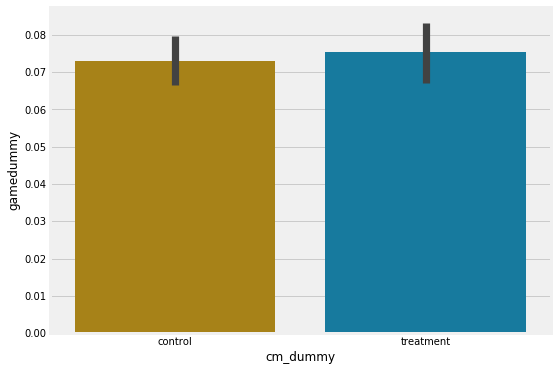

In [33]:
plt.figure(figsize=(8, 6))
df_bar = df.copy()
df_bar['cm_dummy'] = df['cm_dummy'].apply(lambda x: 'treatment' if x == 1 else 'control')
sns.barplot('cm_dummy', 'gamedummy', data=df_bar, palette=['#bf8e00', '#0084b4'])

### 1 - 2. 2群の平均の差 (RCT相当)

In [35]:
naive_avg = df[Z == 1]['gamedummy'].sum() / df[Z == 1].shape[0] - df[Z == 0]['gamedummy'].sum() / df[Z == 0].shape[0]
print(f'2群の平均の差: {naive_avg:.3f}')

2群の平均の差: 0.002


### 2 - 3. 傾向スコア

In [42]:
# IPW推定量で平均処置効果を計算
e_y1 = (1 / sum(Z / PS)) * sum(Z * Y_d / PS) 
e_y0 = (1 / sum((1 - Z) / (1 - PS))) * sum((1 - Z) * Y_d / (1 - PS)) 
ate = e_y1 - e_y0
print(f'IPW推定量によるATE: {ate:.3f}')

IPW推定量によるATE: 0.032


### 2 - 4. CausalML (Uplift Tree)

In [41]:
X_train, X_test, Z_train, Z_test, Y_train, Y_test = train_test_split(X, Z.astype('str'), Y_d, test_size=0.3, random_state=42)
uplift_model = UpliftRandomForestClassifier(evaluationFunction='KL', control_name='0')
uplift_model.fit(X_train.values, treatment=Z_train.values, y=Y_train.values)

Y_hat = uplift_model.predict(X_test.values)
ate_ut = Y_hat.sum() / Y_hat.shape[0]
print(f'Average Treatment Effect (Uplift Tree): {ate_ut:.3f}')

Average Treatment Effect (Uplift Tree): 0.022


## 番外編: 累積Gain Chart と AUUC

---


In [298]:
from cycler import cycler
from causalml.metrics import plot_gain

In [60]:
X_train, X_test, Z_train, Z_test, Y_train, Y_test = train_test_split(X, Z, Y_s, test_size=0.3, random_state=42)
tl = BaseTRegressor(learner=XGBRegressor(random_state=42))
tl.fit(X_train.values, Z_train.values, Y_train.values)
tau_hat = tl.predict(X_test.values)

In [62]:
custom_cycler = (cycler(color=['#0084b4', '#999999']))
plt.rcParams['axes.prop_cycle'] = custom_cycler

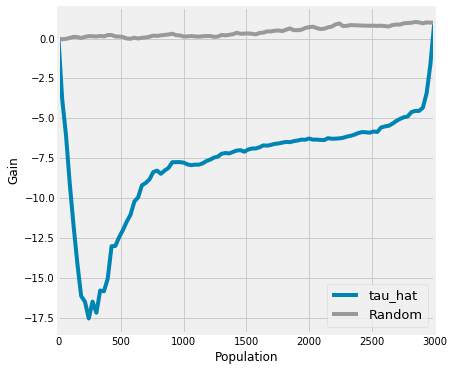

In [70]:
# 単純平均が正になるようにライブラリで調整されている(?)ようで、Gainが逆転している
df_cum_charts = X_test.copy()
df_cum_charts['y_s'] = Y_test.values
df_cum_charts['z'] = Z_test.values
df_cum_charts['tau_hat'] = tau_hat

plot_gain(df_cum_charts[['y_s', 'z', 'tau_hat']], outcome_col='y_s', treatment_col='z',
          normalize=True, figsize=(6, 6))
plt.legend(frameon=True, fontsize=13)

In [104]:
# AUUCも正負が逆転している
auuc_score(df_cum_charts[['y_s', 'z', 'tau_hat']], outcome_col='y_s', treatment_col='z', normalize=True)

tau_hat   -7.829811
Random     0.429075
dtype: float64